In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hardfakevsrealfaces/data.csv
/kaggle/input/hardfakevsrealfaces/fake/fake_218.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_94.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_289.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_507.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_615.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_636.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_160.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_559.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_488.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_93.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_661.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_297.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_610.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_474.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_154.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_308.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_527.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_593.jpg
/kaggle/input/hardfakev

In [2]:
import os
import random
import shutil
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, MobileNetV2


import kagglehub

2025-12-19 02:47:13.972109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766112434.165129      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766112434.220253      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766112434.668361      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766112434.668399      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766112434.668401      23 computation_placer.cc:177] computation placer alr

# 1- Dataset loading

In [3]:
# Download latest version
path = kagglehub.dataset_download("hamzaboulahia/hardfakevsrealfaces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hardfakevsrealfaces


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

fake_dir = os.path.join(path, "fake")
real_dir = os.path.join(path, "real")

image_ext = (".jpg", ".jpeg", ".png")

fake_images = [f for f in os.listdir(fake_dir) if f.endswith(image_ext)]
real_images = [f for f in os.listdir(real_dir) if f.endswith(image_ext)]

print("Fake images:", len(fake_images))
print("Real images:", len(real_images))
print("Total images:", len(fake_images) + len(real_images))

Fake images: 700
Real images: 589
Total images: 1289


# 2- Train / validation / test split

In [5]:
test_size = 0.2

fake_train, fake_test = train_test_split(fake_images, test_size=test_size, random_state=42)
real_train, real_test = train_test_split(real_images, test_size=test_size, random_state=42)

work_dir = "/kaggle/working/dataset_split"
for split in ["train", "test"]:
    for cls in ["fake", "real"]:
        os.makedirs(os.path.join(work_dir, split, cls), exist_ok=True)
def copy_images(files, src_dir, dst_dir):
    for f in files:
        shutil.copy2(os.path.join(src_dir, f), os.path.join(dst_dir, f))

copy_images(fake_train, fake_dir, os.path.join(work_dir, "train", "fake"))
copy_images(real_train, real_dir, os.path.join(work_dir, "train", "real"))

# Copy test images
copy_images(fake_test, fake_dir, os.path.join(work_dir, "test", "fake"))
copy_images(real_test, real_dir, os.path.join(work_dir, "test", "real"))

train_dir = os.path.join(work_dir, "train")
test_dir  = os.path.join(work_dir, "test")

print("\nDataset split")
print(f"Train: {len(fake_train)} fake + {len(real_train)} real")
print(f"Test:  {len(fake_test)} fake + {len(real_test)} real")


Dataset split
Train: 560 fake + 471 real
Test:  140 fake + 118 real


# 3- Data exploration and visualization

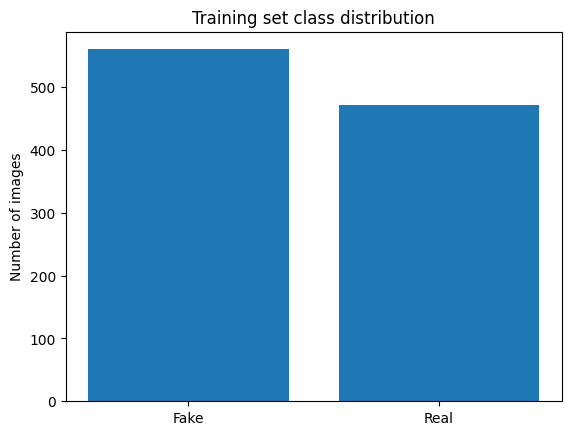

In [6]:
classes = ['Fake', 'Real']
train_counts = [len(fake_train), len(real_train)]

plt.bar(classes, train_counts)
plt.ylabel('Number of images')
plt.title('Training set class distribution')
plt.show()

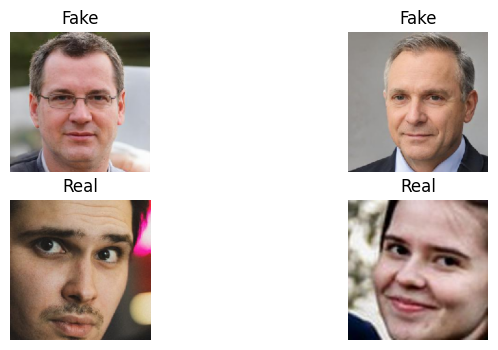

In [7]:
plt.figure(figsize=(8, 4))

# show 2 fake images
for i in range(2):
    img_path = os.path.join(train_dir, 'fake', random.choice(fake_train))
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title('Fake')
    plt.axis('off')

# show 2 real images
for i in range(2):
    img_path = os.path.join(train_dir, 'real', random.choice(real_train))
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 2, i + 3)
    plt.imshow(img)
    plt.title('Real')
    plt.axis('off')

plt.show()

# 4- Data Augmentation

## Data Augmentation Decision:
---------------------------
Use moderate augmentation on the training set only.
Validation and test must stay unchanged for fair evaluation
Faces can appear with small rotations or shifts
We want more variation without destroying fake/real artifacts

Augmentation Applied:
1. Rotation: ±15 degrees (faces can be slightly tilted)
2. Width/Height Shift: 10% (slight position variations)
3. Horizontal Flip: Yes (faces can be mirrored)
4. Zoom: 10% (different face sizes)
5. Fill Mode: Nearest (to avoid artifacts)

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32
N_SPLITS = 5

# Full paths and labels
all_train_files  = [os.path.join(train_dir, 'fake', f) for f in fake_train] + \
                   [os.path.join(train_dir, 'real', f) for f in real_train]
all_train_labels = [0]*len(fake_train) + [1]*len(real_train)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 5- Transfer Learning Model RESNET50

Model Architecture:
ResNet50 Transfer Learning Architecture:
--------------------------------------------------------------------------------
1. Base Model: ResNet50 (pre-trained on ImageNet)
   - Input: 224x224x3 RGB images
   - Architecture: 50 convolutional layers with skip connections
   - Feature extraction: From low-level (edges) to high-level (faces)
   - Status: Initially frozen (weights not updated)

2. Custom Classification Head:
   - GlobalAveragePooling2D: Reduces spatial dimensions
   - Dense(256, ReLU): High-level feature learning
   - Dropout(0.5): Regularization to prevent overfitting
   - Dense(128, ReLU): Further feature refinement
   - Dropout(0.3): Additional regularization
   - Dense(1, Sigmoid): Binary classification output (fake=0, real=1)

In [9]:
def create_model(img_size=IMG_SIZE):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 6- K-Fold Training

## Training Parameters:
-------------------
Loss Function: Binary Crossentropy
  - Suitable for binary classification (fake vs real)
  - Measures difference between predicted and actual probabilities

Optimizer: Adam with learning rate 0.001.

Metrics: Accuracy

Callbacks: EarlyStopping: Stop if val_loss doesn't improve for 7 epochs, restores best weights)

Batch Size: 32
Epochs: 20 (maximum, may stop early)

because of EarlyStopping:

`` early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
) ``
monitor="val_loss" = watches validation loss.

patience=7 =training stops if validation loss does not improve for 7 consecutive epochs.

restore_best_weights=True = keeps the weights from the epoch with the best validation loss.

In [10]:
kfold_df = pd.DataFrame({'filename': all_train_files, 'class': all_train_labels})
kfold_df['class'] = kfold_df['class'].map({0: 'fake', 1: 'real'})

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_val_accuracies, fold_models, fold_histories = [], [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(kfold_df['filename'], kfold_df['class'])):
    print(f"\nFold {fold+1}/{N_SPLITS} ---")

    # Slice the DataFrame directly
    train_gen = train_datagen.flow_from_dataframe(
        kfold_df.iloc[train_idx], x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
    )
    val_gen = valid_datagen.flow_from_dataframe(
        kfold_df.iloc[val_idx], x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
    )

    # Model & Training
    model = create_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[early_stop], verbose=1)

    # Storage
    fold_val_accuracies.append(max(history.history['val_accuracy']))
    fold_histories.append(history.history)
    fold_models.append(model)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Model summary
model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nParameter Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")


Fold 1/5 ---
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


I0000 00:00:1766112452.170675      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766112452.174624      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1766112462.781754      69 service.cc:152] XLA service 0x7864a8002320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766112462.781799      69 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766112462.781805      69 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766112464.644581      69 cuda_dnn.cc:529] Loaded cuDNN version 91002


 2/26 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5703 - loss: 0.8721 

I0000 00:00:1766112469.565480      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 800ms/step - accuracy: 0.5028 - loss: 0.8983 - val_accuracy: 0.4589 - val_loss: 0.7096
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.5005 - loss: 0.7378 - val_accuracy: 0.6473 - val_loss: 0.6846
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - accuracy: 0.5608 - loss: 0.6876 - val_accuracy: 0.5411 - val_loss: 0.6830
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 331ms/step - accuracy: 0.5303 - loss: 0.6911 - val_accuracy: 0.5411 - val_loss: 0.6866
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.5514 - loss: 0.6878 - val_accuracy: 0.5411 - val_loss: 0.6844
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.5462 - loss: 0.6908 - val_accuracy: 0.5411 - val_loss: 0.6834
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.5820 - loss: 0.6883 - val_accuracy: 0.5411 - val_loss: 0.6810
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.5635 - loss: 0.6853 - val_accuracy: 0.5411 - val

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 809ms/step - accuracy: 0.4637 - loss: 0.8460 - val_accuracy: 0.5437 - val_loss: 0.6915
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - accuracy: 0.5231 - loss: 0.7065 - val_accuracy: 0.5437 - val_loss: 0.6841
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.5260 - loss: 0.6940 - val_accuracy: 0.5437 - val_loss: 0.6873
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.5701 - loss: 0.6906 - val_accuracy: 0.5437 - val_loss: 0.6874
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.5682 - loss: 0.6865 - val_accuracy: 0.5437 - val_loss: 0.6862
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.5429 - loss: 0.6889 - val_accuracy: 0.5437 - val_loss: 0.6866
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.5586 - loss: 0.6909 - val_accuracy: 0.5437 - val_loss: 0.6860

Fold 3/5 ---
Found 825 validated image filenames belonging to 2 classes.
Found 206 validated image fil

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 668ms/step - accuracy: 0.4983 - loss: 0.9419 - val_accuracy: 0.5437 - val_loss: 0.6793
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.5349 - loss: 0.6978 - val_accuracy: 0.5437 - val_loss: 0.6815
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.5799 - loss: 0.6791 - val_accuracy: 0.5000 - val_loss: 0.6845
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.4795 - loss: 0.6996 - val_accuracy: 0.5437 - val_loss: 0.6820
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.5203 - loss: 0.6961 - val_accuracy: 0.5437 - val_loss: 0.6786
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.5301 - loss: 0.6903 - val_accuracy: 0.5437 - val_loss: 0.6804
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.5410 - loss: 0.6871 - val_accuracy: 0.5437 - val_loss: 0.6848
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.5659 - loss: 0.6878 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 665ms/step - accuracy: 0.5031 - loss: 0.9179 - val_accuracy: 0.5437 - val_loss: 0.6868
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 0.4884 - loss: 0.7144 - val_accuracy: 0.5437 - val_loss: 0.6868
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.5479 - loss: 0.6891 - val_accuracy: 0.5437 - val_loss: 0.6861
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.5731 - loss: 0.6838 - val_accuracy: 0.5437 - val_loss: 0.6887
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.5302 - loss: 0.6886 - val_accuracy: 0.5437 - val_loss: 0.6885
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.5159 - loss: 0.6926 - val_accuracy: 0.5437 - val_loss: 0.6891
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.5471 - loss: 0.6886 - val_accuracy: 0.5437 - val_loss: 0.6883
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.5241 - loss: 0.6916 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 678ms/step - accuracy: 0.5459 - loss: 0.7830 - val_accuracy: 0.5437 - val_loss: 0.6902
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - accuracy: 0.5269 - loss: 0.7253 - val_accuracy: 0.5437 - val_loss: 0.6840
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.5195 - loss: 0.6961 - val_accuracy: 0.5583 - val_loss: 0.6886
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.5468 - loss: 0.6902 - val_accuracy: 0.5437 - val_loss: 0.6854
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.5338 - loss: 0.6893 - val_accuracy: 0.5437 - val_loss: 0.6850
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - accuracy: 0.5406 - loss: 0.6872 - val_accuracy: 0.5437 - val_loss: 0.6855
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.5498 - loss: 0.6899 - val_accuracy: 0.5437 - val_loss: 0.6828
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.5546 - loss: 0.6868 - val_accuracy: 0

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,374,917 (92.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 524,804 (2.00 MB)


Parameter Summary:
Total parameters: 23,850,113
Trainable parameters: 262,401
Non-trainable parameters: 23,587,712


In [11]:
print("K-FOLD CROSS-VALIDATION RESULTS")
for i, acc in enumerate(fold_val_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")
print(f"\nMean Validation Accuracy: {np.mean(fold_val_accuracies):.4f}")
print(f"Std Deviation: {np.std(fold_val_accuracies):.4f}")
print(f"Best Fold: {np.argmax(fold_val_accuracies) + 1} ({max(fold_val_accuracies):.4f})")

K-FOLD CROSS-VALIDATION RESULTS
Fold 1: 0.6473
Fold 2: 0.5437
Fold 3: 0.5437
Fold 4: 0.5437
Fold 5: 0.7184

Mean Validation Accuracy: 0.5994
Std Deviation: 0.0718
Best Fold: 5 (0.7184)


# 7- Training Curves (Best fold - Before Fine-tuning)

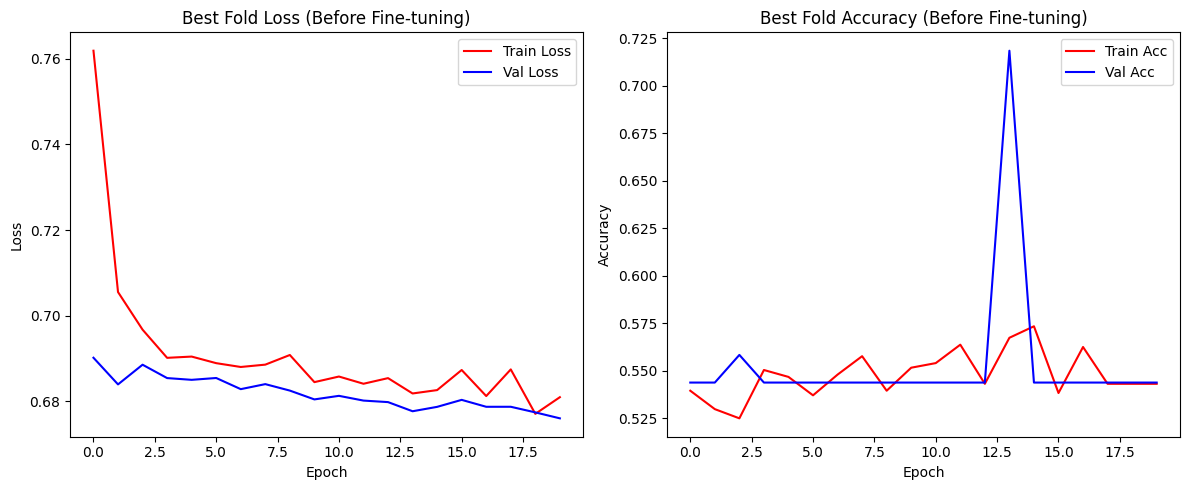

In [12]:
best_fold_idx = np.argmax(fold_val_accuracies)
best_fold_history = fold_histories[best_fold_idx]

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(best_fold_history['loss'], 'r', label='Train Loss')
plt.plot(best_fold_history['val_loss'], 'b', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Best Fold Loss (Before Fine-tuning)')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(best_fold_history['accuracy'], 'r', label='Train Acc')
plt.plot(best_fold_history['val_accuracy'], 'b', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Best Fold Accuracy (Before Fine-tuning)')
plt.legend()

plt.tight_layout()
plt.show()

# 8- Fine-Tuning (Best Fold)

In [13]:
# Select the best model from the K-Fold results
best_model = fold_models[np.argmax(fold_val_accuracies)]

# Split the df created in Step 6 into train and validation
train_df, val_df = train_test_split(
    kfold_df, test_size=0.1, random_state=42, stratify=kfold_df['class']
)

# Quick Generator setup using the split DataFrames
full_train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)
full_val_gen = valid_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# Unfreeze the last 15 layers of the base ResNet50 model
base_model = best_model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Re-compile and Fine-tune
best_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune_full = best_model.fit(
    full_train_gen, validation_data=full_val_gen,
    epochs=20, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Found 927 validated image filenames belonging to 2 classes.
Found 104 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 871ms/step - accuracy: 0.5646 - loss: 0.6692 - val_accuracy: 0.5385 - val_loss: 0.6730
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.5791 - loss: 0.6304 - val_accuracy: 0.5385 - val_loss: 0.6693
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.6287 - loss: 0.6141 - val_accuracy: 0.5385 - val_loss: 0.6637
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.6904 - loss: 0.5535 - val_accuracy: 0.5385 - val_loss: 0.6556
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.7841 - loss: 0.5129 - val_accuracy: 0.5385 - val_loss: 0.6439
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.8212 - loss: 0.4621 - val_accuracy: 0.5385 - val_loss: 0.6125
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.8603 - loss: 0.4091 - val_accuracy: 0.5385 - val_loss: 0.5789
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.8594 - loss: 0.3920 - val_accu

In [14]:
# Save best model
best_model.save("/kaggle/working/best_resnet50_model.keras")

print("Best model saved!")

Best model saved!


# 9- Training Curves after Fine-Tuning

## Feature Extraction Phase Plot (Best Fold)

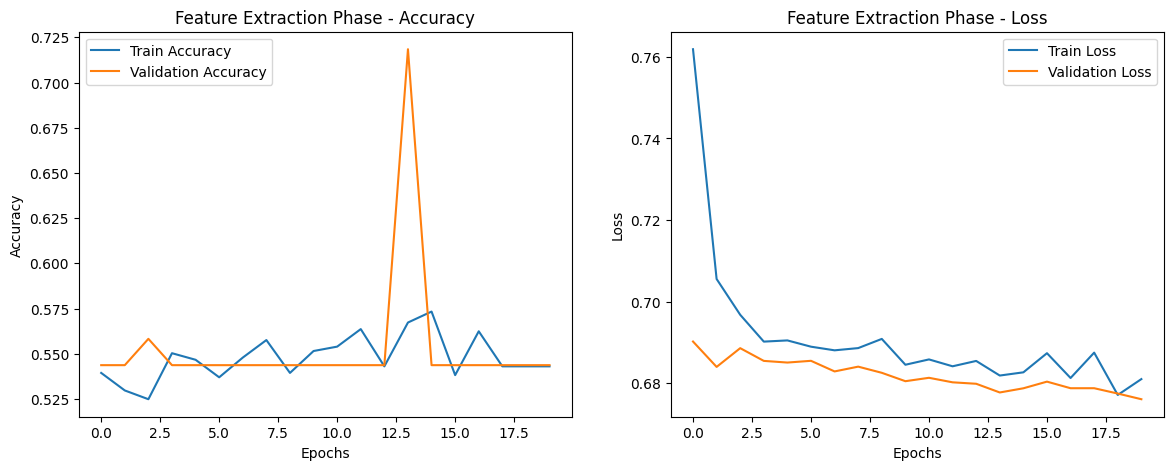

In [15]:
# ===== FEATURE EXTRACTION PHASE =====
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(best_fold_history['accuracy'], label='Train Accuracy')
plt.plot(best_fold_history['val_accuracy'], label='Validation Accuracy')
plt.title('Feature Extraction Phase - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(best_fold_history['loss'], label='Train Loss')
plt.plot(best_fold_history['val_loss'], label='Validation Loss')
plt.title('Feature Extraction Phase - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Fine-Tuning Phase Plot (Full Training)

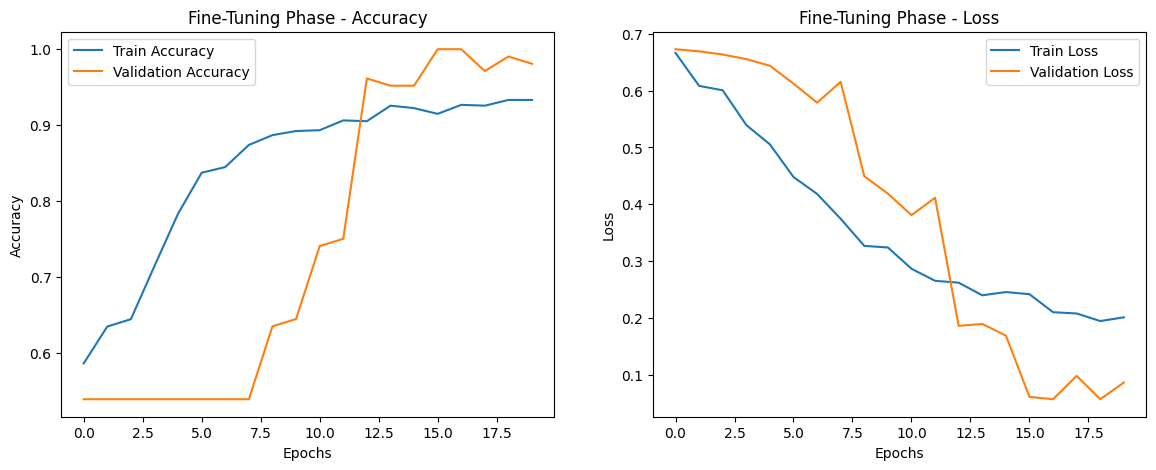

In [16]:
# ===== FINE-TUNING PHASE =====
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_finetune_full.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune_full.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-Tuning Phase - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_finetune_full.history['loss'], label='Train Loss')
plt.plot(history_finetune_full.history['val_loss'], label='Validation Loss')
plt.title('Fine-Tuning Phase - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
# Use max values instead of last epoch
final_train_acc = max(best_fold_history['accuracy'])
final_val_acc = max(history_finetune_full.history['val_accuracy'])
gap = final_train_acc - final_val_acc

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Train-Val Gap: {gap:.4f}")

if gap < 0.05:
    print("Minimal overfitting")
elif gap < 0.10:
    print("Slight overfitting")
else:
    print("Significant overfitting")


Final Training Accuracy: 0.5733
Final Validation Accuracy: 1.0000
Train-Val Gap: -0.4267
Minimal overfitting


In [18]:
with open("/kaggle/working/best_fold_history.json", "w") as f:
    json.dump(best_fold_history, f)

with open("/kaggle/working/history_finetune_full.json", "w") as f:
    json.dump(history_finetune_full.history, f)

# 10- Test Set Evaluation

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 627ms/step

Test Accuracy : 0.9729
Test Precision: 0.9587
Test Recall   : 0.9831
Test F1-score : 0.9707

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.96      0.97       140
        Real       0.96      0.98      0.97       118

    accuracy                           0.97       258
   macro avg       0.97      0.97      0.97       258
weighted avg       0.97      0.97      0.97       258



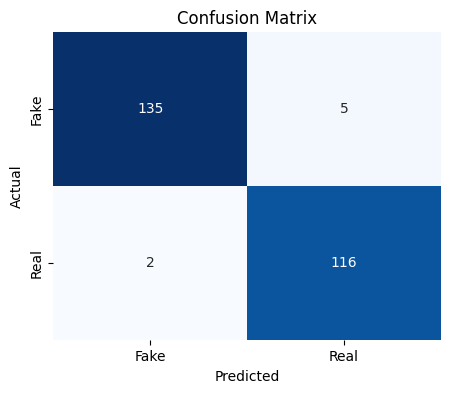

In [19]:
test_gen.reset()
y_pred_probs = best_model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Metrics
test_acc = accuracy_score(y_true, y_pred)
test_prec = precision_score(y_true, y_pred)
test_rec = recall_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print(f"\nTest Accuracy : {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall   : {test_rec:.4f}")
print(f"Test F1-score : {test_f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake','Real']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 11- Hyperparameter experiments

In [20]:
def train_model(batch_size=32, lr=0.001, epochs=10, use_early_stop=False):
    # Create a simple train/val split from all_train_files
    train_files_temp, val_files_temp, train_labels_temp, val_labels_temp = train_test_split(
        all_train_files, all_train_labels, test_size=0.2, random_state=42, stratify=all_train_labels
    )
    
    # Convert to DataFrames
    train_df_temp = pd.DataFrame({'filename': train_files_temp, 'class': train_labels_temp})
    val_df_temp = pd.DataFrame({'filename': val_files_temp, 'class': val_labels_temp})
    label_map = {0: 'fake', 1: 'real'}
    train_df_temp['class'] = train_df_temp['class'].map(label_map)
    val_df_temp['class'] = val_df_temp['class'].map(label_map)
    
    # Generators
    train_gen_temp = train_datagen.flow_from_dataframe(
        train_df_temp, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=batch_size, class_mode='binary'
    )
    val_gen_temp = valid_datagen.flow_from_dataframe(
        val_df_temp, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=batch_size, class_mode='binary', shuffle=False
    )
    
    # Create model
    model_temp = create_model()
    
    # Update learning rate
    model_temp.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks_list = []
    if use_early_stop:
        callbacks_list.append(EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))
    
    # Train
    history_temp = model_temp.fit(
        train_gen_temp,
        validation_data=val_gen_temp,
        epochs=epochs,
        callbacks=callbacks_list,
        verbose=0  # Silent training
    )
    
    # Return best validation accuracy
    best_val_acc = max(history_temp.history['val_accuracy'])
    return best_val_acc

Experiments: 3 batch sizes, 3 learning rates, 3 epoch values, with/without early stopping

In [21]:
# EXPERIMENT 1: Effect of BATCH SIZE (fix other params)
print("\n1. Testing Batch Size Effect:")
batch_results = []
for bs in [16, 32, 64]:
    val_acc = train_model(batch_size=bs, lr=0.001, epochs=10, use_early_stop=True)
    batch_results.append({'Batch Size': bs, 'Val Accuracy': val_acc})
    print(f"  Batch Size {bs}: Val Acc = {val_acc:.4f}")


1. Testing Batch Size Effect:
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Batch Size 16: Val Acc = 0.5411
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Batch Size 32: Val Acc = 0.5411
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Batch Size 64: Val Acc = 0.5411


In [22]:
# EXPERIMENT 2: Effect of LEARNING RATE
print("\n2. Testing Learning Rate Effect:")
lr_results = []
for lr in [0.001, 0.0005, 0.0001]:
    val_acc = train_model(batch_size=32, lr=lr, epochs=10, use_early_stop=True)
    lr_results.append({'Learning Rate': lr, 'Val Accuracy': val_acc})
    print(f"  Learning Rate {lr}: Val Acc = {val_acc:.4f}")


2. Testing Learning Rate Effect:
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Learning Rate 0.001: Val Acc = 0.5411
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Learning Rate 0.0005: Val Acc = 0.5604
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Learning Rate 0.0001: Val Acc = 0.5411


In [23]:
# EXPERIMENT 3: Effect of EPOCHS
print("\n3. Testing Epochs Effect:")
epoch_results = []
for ep in [5, 10, 20]:
    val_acc = train_model(batch_size=32, lr=0.001, epochs=ep, use_early_stop=False)
    epoch_results.append({'Epochs': ep, 'Val Accuracy': val_acc})
    print(f"  Epochs {ep}: Val Acc = {val_acc:.4f}")


3. Testing Epochs Effect:
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Epochs 5: Val Acc = 0.5749
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Epochs 10: Val Acc = 0.5411
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Epochs 20: Val Acc = 0.6039


In [24]:
# EXPERIMENT 4: Effect of EARLY STOPPING
print("\n4. Testing Early Stopping Effect:")
es_results = []
for es in [True, False]:
    val_acc = train_model(batch_size=32, lr=0.001, epochs=20, use_early_stop=es)
    es_results.append({'Early Stopping': es, 'Val Accuracy': val_acc})
    print(f"  Early Stopping {es}: Val Acc = {val_acc:.4f}")


4. Testing Early Stopping Effect:
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Early Stopping True: Val Acc = 0.5459
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  Early Stopping False: Val Acc = 0.5411


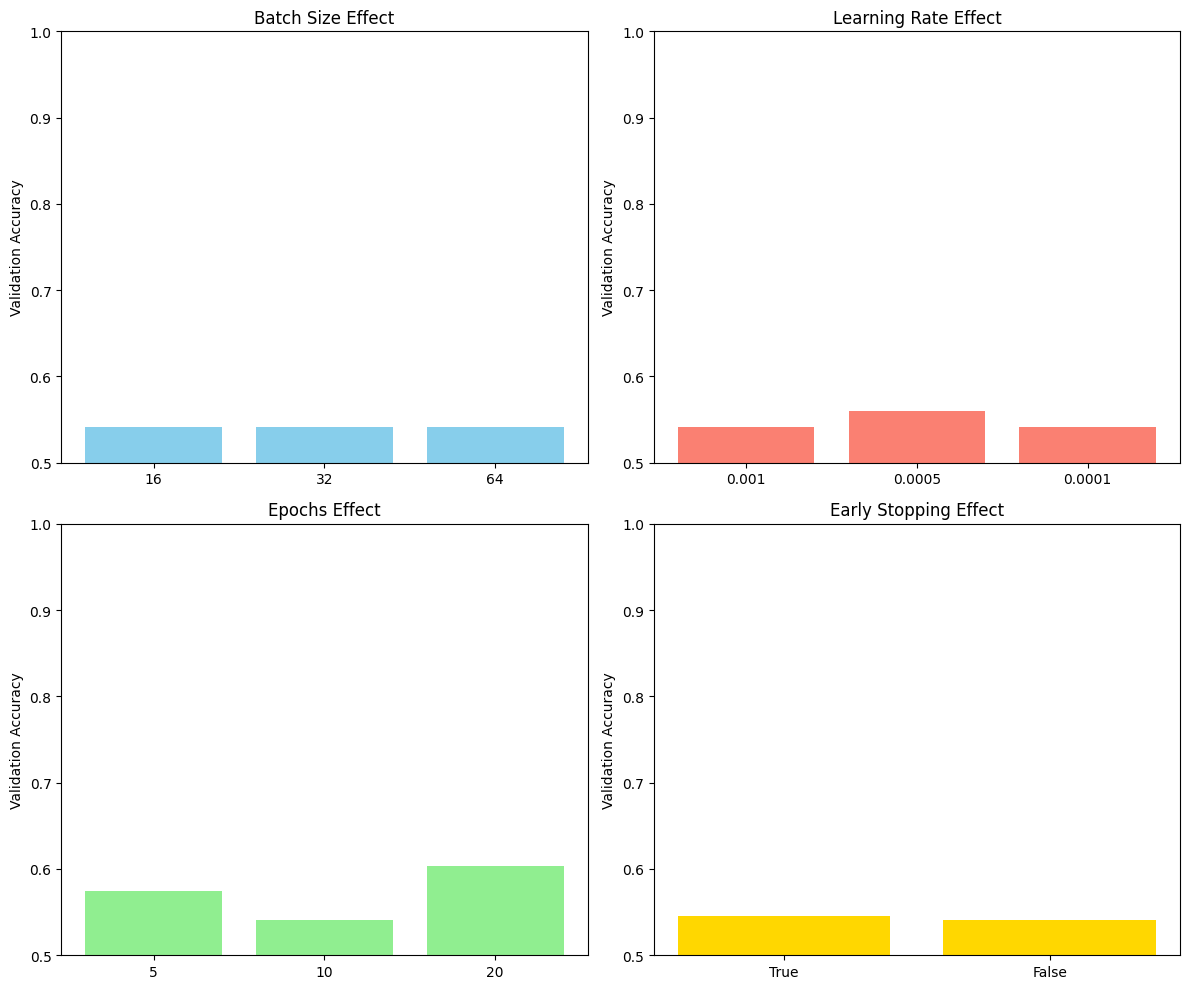

In [25]:
df_batch = pd.DataFrame(batch_results)
df_lr    = pd.DataFrame(lr_results)
df_epoch = pd.DataFrame(epoch_results)
df_es    = pd.DataFrame(es_results)

# Plot all 4 hyperparameter effects in one figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot function to reduce repetition
def plot_bar(ax, df, x_col, y_col, color, title):
    ax.bar(df[x_col].astype(str), df[y_col], color=color)
    ax.set_title(title)
    ax.set_ylabel('Validation Accuracy')
    ax.set_ylim([0.5, 1.0])

plot_bar(axes[0,0], df_batch, 'Batch Size', 'Val Accuracy', 'skyblue', 'Batch Size Effect')
plot_bar(axes[0,1], df_lr,    'Learning Rate', 'Val Accuracy', 'salmon', 'Learning Rate Effect')
plot_bar(axes[1,0], df_epoch, 'Epochs', 'Val Accuracy', 'lightgreen', 'Epochs Effect')
plot_bar(axes[1,1], df_es,    'Early Stopping', 'Val Accuracy', 'gold', 'Early Stopping Effect')

plt.tight_layout()
plt.savefig('hyperparameter_effects.png', dpi=300, bbox_inches='tight')
plt.show() 

In [26]:
# Summary table
print("HYPERPARAMETER EXPERIMENT SUMMARY")
print("\nBatch Size Results:")
print(df_batch.to_string(index=False))
print("\nLearning Rate Results:")
print(df_lr.to_string(index=False))
print("\nEpochs Results:")
print(df_epoch.to_string(index=False))
print("\nEarly Stopping Results:")
print(df_es.to_string(index=False))

# Analysis
print("HYPERPARAMETER ANALYSIS")
print(f"""
Best Batch Size: {df_batch.loc[df_batch['Val Accuracy'].idxmax(), 'Batch Size']}
Best Learning Rate: {df_lr.loc[df_lr['Val Accuracy'].idxmax(), 'Learning Rate']}
Best Epochs: {df_epoch.loc[df_epoch['Val Accuracy'].idxmax(), 'Epochs']}
Early Stopping Benefit: {df_es.loc[df_es['Early Stopping']==True, 'Val Accuracy'].values[0] - df_es.loc[df_es['Early Stopping']==False, 'Val Accuracy'].values[0]:.4f}

Key Findings:
- Batch size impact: {'Significant' if df_batch['Val Accuracy'].max() - df_batch['Val Accuracy'].min() > 0.05 else 'Minimal'}
- Learning rate sensitivity: {'High' if df_lr['Val Accuracy'].max() - df_lr['Val Accuracy'].min() > 0.05 else 'Low'}
- Training duration: {'More epochs help' if df_epoch['Val Accuracy'].iloc[-1] > df_epoch['Val Accuracy'].iloc[0] else 'Converges early'}
- Early stopping: {'Beneficial' if df_es.loc[df_es['Early Stopping']==True, 'Val Accuracy'].values[0] > df_es.loc[df_es['Early Stopping']==False, 'Val Accuracy'].values[0] else 'Not necessary'}
""")

HYPERPARAMETER EXPERIMENT SUMMARY

Batch Size Results:
 Batch Size  Val Accuracy
         16      0.541063
         32      0.541063
         64      0.541063

Learning Rate Results:
 Learning Rate  Val Accuracy
        0.0010      0.541063
        0.0005      0.560386
        0.0001      0.541063

Epochs Results:
 Epochs  Val Accuracy
      5      0.574879
     10      0.541063
     20      0.603865

Early Stopping Results:
 Early Stopping  Val Accuracy
           True      0.545894
          False      0.541063
HYPERPARAMETER ANALYSIS

Best Batch Size: 16
Best Learning Rate: 0.0005
Best Epochs: 20
Early Stopping Benefit: 0.0048

Key Findings:
- Batch size impact: Minimal
- Learning rate sensitivity: Low
- Training duration: More epochs help
- Early stopping: Beneficial



# 12- Bonus Section

## Integrating Extra Layers into ResNet50

In [27]:
# Create fresh train/val split for bonus models
train_df_bonus, val_df_bonus = train_test_split(
    kfold_df, test_size=0.2, random_state=42, stratify=kfold_df['class']
)

train_gen_bonus = train_datagen.flow_from_dataframe(
    train_df_bonus, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)
val_gen_bonus = valid_datagen.flow_from_dataframe(
    val_df_bonus, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


In [28]:
base_model_b1 = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model_b1.trainable = False

model_bonus1 = models.Sequential([
    base_model_b1,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_bonus1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model_bonus1.summary()

# Use the best fold's data for training
train_gen.reset()
val_gen.reset()

history_bonus1 = model_bonus1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate on test set
test_gen.reset()
y_pred_bonus1 = model_bonus1.predict(test_gen)
y_pred_bonus1 = (y_pred_bonus1 > 0.5).astype(int).flatten()

acc_bonus1 = accuracy_score(test_gen.classes, y_pred_bonus1)
prec_bonus1 = precision_score(test_gen.classes, y_pred_bonus1)
rec_bonus1 = recall_score(test_gen.classes, y_pred_bonus1)
f1_bonus1 = f1_score(test_gen.classes, y_pred_bonus1)

print(f"\nBonus Model 1 Test Results:")
print(f"  Accuracy:  {acc_bonus1:.4f}")
print(f"  Precision: {prec_bonus1:.4f}")
print(f"  Recall:    {rec_bonus1:.4f}")
print(f"  F1-Score:  {f1_bonus1:.4f}")


Model Architecture:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 723ms/step - accuracy: 0.5288 - loss: 0.8087 - val_accuracy: 0.5437 - val_loss: 0.7024
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.5032 - loss: 0.7461 - val_accuracy: 0.5437 - val_loss: 0.6886
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 355ms/step - accuracy: 0.5488 - loss: 0.6993 - val_accuracy: 0.5437 - val_loss: 0.6828
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.5590 - loss: 0.6925 - val_accuracy: 0.6311 - val_loss: 0.6836
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.5576 - loss: 0.6913 - val_accuracy: 0.6019 - val_loss: 0.6892
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.5287 - loss: 0.6901 - val_accuracy: 0.5437 - val_loss: 0.6833
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - accuracy: 0.5520 - loss: 0.6859 - val_accuracy: 0.5437 - val_loss: 0.6798
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.5376 - loss: 0.7024 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Combining Two CNN Architectures 

combine ResNet50 + MobileNetV2 by concatenating their features before classification.

In [29]:
# Load base models
resnet_b2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobilenet_b2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
resnet_b2.trainable = False
mobilenet_b2.trainable = False

# Build fusion architecture
x1 = layers.GlobalAveragePooling2D()(resnet_b2.output)
x2 = layers.GlobalAveragePooling2D()(mobilenet_b2.output)
combined = layers.Concatenate()([x1, x2])
combined = layers.Dense(256, activation='relu')(combined)
combined = layers.Dropout(0.5)(combined)
output = layers.Dense(1, activation='sigmoid')(combined)

model_bonus2 = Model(inputs=[resnet_b2.input, mobilenet_b2.input], outputs=output)

model_bonus2.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model_bonus2.summary()

# Dual generator for two inputs
def dual_generator(generator):
    for batch_x, batch_y in generator:
        yield (batch_x, batch_x), batch_y  
        
train_gen_bonus.reset()
val_gen_bonus.reset()
test_gen.reset()

history_bonus2 = model_bonus2.fit(
    dual_generator(train_gen_bonus),
    steps_per_epoch=len(train_gen_bonus),
    validation_data=dual_generator(val_gen_bonus),
    validation_steps=len(val_gen_bonus),
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate on test set
test_gen.reset()
y_pred_bonus2 = model_bonus2.predict(
    dual_generator(test_gen),
    steps=len(test_gen)
)
y_pred_bonus2 = (y_pred_bonus2 > 0.5).astype(int).flatten()

acc_bonus2 = accuracy_score(test_gen.classes, y_pred_bonus2)
prec_bonus2 = precision_score(test_gen.classes, y_pred_bonus2)
rec_bonus2 = recall_score(test_gen.classes, y_pred_bonus2)
f1_bonus2 = f1_score(test_gen.classes, y_pred_bonus2)

print(f"\nBonus Model 2 Test Results:")
print(f"  Accuracy:  {acc_bonus2:.4f}")
print(f"  Precision: {prec_bonus2:.4f}")
print(f"  Recall:    {rec_bonus2:.4f}")
print(f"  F1-Score:  {f1_bonus2:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Architecture:


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_34[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_35      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c

 Total params: 26,698,177 (101.85 MB)

 Trainable params: 852,481 (3.25 MB)

 Non-trainable params: 25,845,696 (98.59 MB)

Epoch 1/20


2025-12-19 03:26:25.543857: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 03:26:25.682194: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 03:26:25.819300: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6781 - loss: 0.7718

2025-12-19 03:26:46.492352: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 03:26:46.630158: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.6832 - loss: 0.7591

2025-12-19 03:27:06.586653: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 03:27:06.723707: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


26/26 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.6879 - loss: 0.7473 - val_accuracy: 0.9807 - val_loss: 0.0795
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.9678 - loss: 0.1150 - val_accuracy: 0.9821 - val_loss: 0.0674
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.9771 - loss: 0.0762 - val_accuracy: 0.9911 - val_loss: 0.0381
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - accuracy: 0.9775 - loss: 0.0627 - val_accuracy: 0.9710 - val_loss: 0.0602
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.9793 - loss: 0.0966 - val_accuracy: 0.9517 - val_loss: 0.0921
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.9855 - loss: 0.0488 - val_accuracy: 0.9758 - val_loss: 0.0458
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.9889 - loss: 0.0389 - val_accuracy: 0.9903 - val_loss: 0.0309
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step - accuracy: 0.9871 - loss: 0.0351 - val_accuracy: 0.9903 - val_lo

2025-12-19 03:29:29.877067: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 03:29:30.013182: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step

Bonus Model 2 Test Results:
  Accuracy:  0.9922
  Precision: 1.0000
  Recall:    0.9831
  F1-Score:  0.9915


In [30]:
# COMPARISON TABLE
print("MODEL COMPARISON")

comparison_df = pd.DataFrame({
    'Model': ['Base ResNet50', 'Enhanced ResNet50', 'ResNet+MobileNet Fusion'],
    'Parameters': [
        f"{best_model.count_params():,}",
        f"{model_bonus1.count_params():,}",
        f"{model_bonus2.count_params():,}"
    ],
    'Accuracy': [test_acc, acc_bonus1, acc_bonus2],
    'Precision': [test_prec, prec_bonus1, prec_bonus2],
    'Recall': [test_rec, rec_bonus1, rec_bonus2],
    'F1-Score': [test_f1, f1_bonus1, f1_bonus2]
})

print("\n" + comparison_df.to_string(index=False))

# analysis
print("BONUS MODELS ANALYSIS")

improvement_bonus1 = acc_bonus1 - test_acc
improvement_bonus2 = acc_bonus2 - test_acc

print(f"""
Enhanced ResNet50 (Bonus 1):
- Architecture: Added Dense(256) → Dense(128) with Dropout layers
- Accuracy Change: {improvement_bonus1:+.4f} ({'Improved' if improvement_bonus1 > 0 else 'Degraded'})
- Trade-off: {model_bonus1.count_params() - best_model.count_params():,} additional parameters

ResNet+MobileNet Fusion (Bonus 2):
- Architecture: Combined ResNet50 and MobileNetV2 features
- Accuracy Change: {improvement_bonus2:+.4f} ({'Improved' if improvement_bonus2 > 0 else 'Degraded'})
- Trade-off: {model_bonus2.count_params() - best_model.count_params():,} additional parameters
- Complexity: ~2x inference time due to dual architecture

Conclusion:
{'The bonus models demonstrate that ' + ('architectural enhancements can improve performance' if max(improvement_bonus1, improvement_bonus2) > 0.01 else 'the base model is already well-optimized') + ' for this dataset.'}
""")

MODEL COMPARISON

                  Model Parameters  Accuracy  Precision   Recall  F1-Score
          Base ResNet50 23,850,113  0.972868   0.958678 0.983051  0.970711
      Enhanced ResNet50 24,145,281  0.542636   0.000000 0.000000  0.000000
ResNet+MobileNet Fusion 26,698,177  0.992248   1.000000 0.983051  0.991453
BONUS MODELS ANALYSIS

Enhanced ResNet50 (Bonus 1):
- Architecture: Added Dense(256) → Dense(128) with Dropout layers
- Accuracy Change: -0.4302 (Degraded)
- Trade-off: 295,168 additional parameters

ResNet+MobileNet Fusion (Bonus 2):
- Architecture: Combined ResNet50 and MobileNetV2 features
- Accuracy Change: +0.0194 (Improved)
- Trade-off: 2,848,064 additional parameters
- Complexity: ~2x inference time due to dual architecture

Conclusion:
The bonus models demonstrate that architectural enhancements can improve performance for this dataset.



In [31]:
results = {
    "kfold": {
        "fold_accuracies": fold_val_accuracies,
        "mean_accuracy": float(np.mean(fold_val_accuracies)),
        "std": float(np.std(fold_val_accuracies))
    },
    "test_metrics": {
        "accuracy": float(test_acc),
        "precision": float(test_prec),
        "recall": float(test_rec),
        "f1": float(test_f1)
    },
    "bonus_models": {
        "enhanced_resnet": {
            "accuracy": float(acc_bonus1),
            "f1": float(f1_bonus1)
        },
        "fusion_model": {
            "accuracy": float(acc_bonus2),
            "f1": float(f1_bonus2)
        }
    }
}

with open("/kaggle/working/results_summary.json", "w") as f:
    json.dump(results, f, indent=4)

print("Results summary saved!")

Results summary saved!
